In [1]:
import numpy
import scipy
from scipy.optimize import minimize,brute
from joblib import Parallel, delayed
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from copy import deepcopy
import itertools
from sklearn.linear_model import LinearRegression
from pomegranate import *

In [4]:
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import *

use pomegranate to do model fit

In [8]:
arena_r = 1.5
d1_true = Normal(means=[0],covs=[0.05])
d2_true = Uniform(mins=[-arena_r],maxs=[arena_r])
truemodel = GeneralMixtureModel([d1_true, d2_true],priors=[0.9,0.1])
model = GeneralMixtureModel([d1, d2])
truemodel.
model.fit()

In [3]:
study_dir = r"E:\pirate_fmri\Analysis\data\Exp2_pilots\3_M2_V2"
data_dir = os.path.join(study_dir,"data","json")
param_dir = os.path.join(study_dir,"data","param")

org_data = pd.read_csv(os.path.join(study_dir,"task_data.csv"))
valid_exptid = np.unique(org_data.subid)

In [7]:
subdf = org_data[(org_data.subid==valid_exptid[0])&(org_data.ctrl_ept==1)].copy().reset_index(drop=True)
ts_df = org_data[(org_data.ctrl_ept==1)&(org_data.expt_task==0)].copy().reset_index(drop=True)
for gname,g_df in ts_df.groupby(["subid","expt_session","expt_block","expt_map","stim_group"]):
    g_df

In [9]:
subdf = org_data[(org_data.subid==id)&(org_data.ctrl_ept==1)].copy().reset_index(drop=True)
sub_trian_df = subdf[(subdf.expt_session==1)&(subdf.expt_block==8*2+4)]
np.unique(sub_trian_df.ctrl_fb)
sub_trian_df_resp = sub_trian_df.groupby(["subid","expt_map","x_axisset","y_axisset","istraining","stim_id","stim_x","stim_y"])[["resp_x","resp_y"]].mean().reset_index()
sub_trian_df_resp    
sub_trainingresp=sub_trian_df_resp[sub_trian_df_resp.istraining==True].copy().reset_index(drop=True)
sub_trainingresp

,subid,expt_map,x_axisset,y_axisset,istraining,stim_id,stim_x,stim_y,resp_x,resp_y
0,MJQxtcr3UsX3,0,x1,y1,1,2,-3.4,0.0,-3.703704,-1.736111
1,MJQxtcr3UsX3,0,x1,y1,1,12,-1.7,0.0,-1.719577,-1.934524
2,MJQxtcr3UsX3,0,x1,y1,1,20,0.0,-3.4,-3.290344,-3.207672
3,MJQxtcr3UsX3,0,x1,y1,1,21,0.0,-1.7,1.934524,-1.256614
4,MJQxtcr3UsX3,0,x1,y1,1,23,0.0,1.7,1.785714,0.413360
5,MJQxtcr3UsX3,0,x1,y1,1,24,0.0,3.4,1.967593,2.827381
6,MJQxtcr3UsX3,0,x1,y1,1,32,1.7,0.0,1.653439,0.727513
7,MJQxtcr3UsX3,0,x1,y1,1,42,3.4,0.0,1.934524,0.446429
8,MJQxtcr3UsX3,1,x2,y2,1,57,-3.4,0.0,-4.183201,-0.347222
9,MJQxtcr3UsX3,1,x2,y2,1,67,-1.7,0.0,-1.306217,-1.653439


In [5]:
putativerespdata_all = []
for id in valid_exptid:
    # find the refresherb blocks
    n_pretrain_permap = 8
    n_map = 2
    n_refresh_permap = 4
    refresher_block_idices = n_pretrain_permap*n_map+np.arange(n_refresh_permap)
    subdf = org_data[(org_data.subid==id)&(org_data.ctrl_ept==1)&(org_data.ctrl_ept==1)&(org_data.expt_task==0)].copy().reset_index(drop=True)
    subdf = subdf[[b not in refresher_block_idices for b in subdf.expt_block]].copy().reset_index(drop=True)
    
    sub_resp_ave_df = subdf.groupby(["subid","expt_session","expt_block","expt_map","x_axisset","y_axisset","stim_group","istraining","stim_id","stim_x","stim_y"])[["resp_x","resp_y"]].mean().reset_index()
    # the data frame used to derive putative response
    sub_trainingresp=sub_resp_ave_df[sub_resp_ave_df.istraining==True].copy().reset_index(drop=True)
    sub_resp=sub_resp_ave_df

    putative_xs = compose_pattern_from_reference(sub_resp[["stim_x"]].to_numpy(),
                                sub_trainingresp[["resp_x"]].to_numpy(),
                                sub_trainingresp[["stim_x"]].to_numpy(),
                                source_controlfeatures=sub_resp[["x_axisset","expt_block"]].to_numpy(),
                                reference_controlfeatures=sub_trainingresp[["x_axisset","expt_block"]].to_numpy())
    putative_ys = compose_pattern_from_reference(sub_resp[["stim_y"]].to_numpy(),
                                sub_trainingresp[["resp_y"]].to_numpy(),
                                sub_trainingresp[["stim_y"]].to_numpy(),
                                source_controlfeatures=sub_resp[["y_axisset","expt_block"]].to_numpy(),
                                reference_controlfeatures=sub_trainingresp[["y_axisset","expt_block"]].to_numpy())
    sub_resp["putative_x"] = putative_xs
    sub_resp["putative_y"] = putative_ys
    putativerespdata_all.append(sub_resp)

In [6]:
putativerespdata_all_df = pd.concat(putativerespdata_all).reset_index(drop=True)
putativerespdata_all_df

,subid,expt_session,expt_block,expt_map,x_axisset,y_axisset,stim_group,istraining,stim_id,stim_x,stim_y,resp_x,resp_y,putative_x,putative_y
0,0en2YwrgPZqq,0,0,0,x1,y1,training,1,2,-3.4,0.0,1.405423,0.702712,1.405423,0.231481
1,0en2YwrgPZqq,0,0,0,x1,y1,training,1,12,-1.7,0.0,0.132275,0.157077,0.132275,0.231481
2,0en2YwrgPZqq,0,0,0,x1,y1,training,1,20,0.0,-3.4,2.992725,-0.248016,1.087136,-0.248016
3,0en2YwrgPZqq,0,0,0,x1,y1,training,1,21,0.0,-1.7,-0.033069,-0.140542,1.087136,-0.140542
4,0en2YwrgPZqq,0,0,0,x1,y1,training,1,23,0.0,1.7,-0.099206,2.711640,1.087136,2.711640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13879,xZoeR59rDXFN,1,20,3,x2,y1,test,0,90,3.4,-3.4,3.240741,-3.425926,-3.558201,-3.399471
13880,xZoeR59rDXFN,1,20,3,x2,y1,test,0,91,3.4,-1.7,-3.571429,-1.772487,-3.558201,-1.587302
13881,xZoeR59rDXFN,1,20,3,x2,y1,test,0,92,3.4,0.0,3.412698,-0.185185,-3.558201,-0.049603
13882,xZoeR59rDXFN,1,20,3,x2,y1,test,0,93,3.4,1.7,4.179894,1.468254,-3.558201,1.574074


In [15]:
def compute_regression(respxs,respys,putativexs,putativeys):
    return [scipy.stats.linregress(putativexs,respxs).slope, scipy.stats.linregress(putativeys,respys).slope]
strategy_dfs = []
for gname,g_df in putativerespdata_all_df[putativerespdata_all_df.istraining==False].groupby(["subid","expt_session","expt_block","expt_map"]):
    subid, sess, block, map = gname    
    gdict = dict(zip(["subid","expt_session","expt_block","expt_map"],gname))
    beta_x,beta_y = compute_regression(*list(g_df[["resp_x","resp_y","putative_x","putative_y"]].to_numpy().T))
    gdict.update({"beta_putativex":beta_x,"beta_putativey":beta_y})
    strategy_dfs.append(gdict)
strategy_df = pd.concat([pd.DataFrame(d,index=[0]) for d in strategy_dfs],axis=0).reset_index(drop=True)

In [40]:
np.unique(putativerespdata_all_df[putativerespdata_all_df.istraining==False]["expt_map"])


array([0, 1, 2, 3], dtype=int64)

In [36]:
strategy_df.to_csv(os.path.join(study_dir,"compo_strategy.csv"))

In [29]:
strategy_df["xyratio"] = [x/(x+y) for x,y in strategy_df[["beta_putativex","beta_putativey"]].to_numpy()]

(0.0, 1.0)

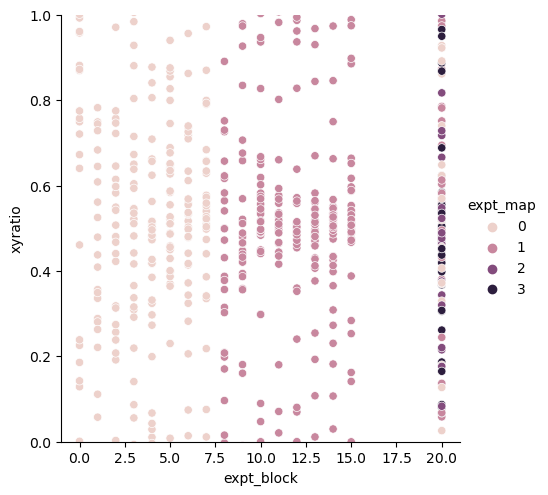

In [33]:
strategy_df.head(5)
gs = sns.relplot(strategy_df,
            x="expt_block",
            y="xyratio",
            hue="expt_map")
gs.axes.flatten()[0].set_ylim([0,1])

In [15]:
putativerespdata_test = []
for id in valid_exptid:
    subdf = org_data[(org_data.subid==id)&(org_data.ctrl_ept==1)].copy().reset_index(drop=True)
    
    # find the final block of each map in test
    n_pretrain_permap = 8
    n_map = 2
    n_refresh_permap = 4
    test_block_idx = n_pretrain_permap*n_map+n_refresh_permap
    sub_testblock_df = subdf[(subdf.expt_session==1)&(subdf.expt_block==test_block_idx)].copy().reset_index(drop=True)
    #sub_testblock_df.groupby(["subid","expt_map","x_axisset","y_axisset","stim_group","istraining","stim_id","stim_x","stim_y"])[["resp_x","resp_y"]].mean().reset_index()
    # the data frame used to derive putative response
    sub_trainingresp=sub_testblock_df[sub_testblock_df.istraining==True].copy().reset_index(drop=True)
    sub_resp=sub_testblock_df.copy()
    
    putative_xs = compose_pattern_from_reference(sub_resp[["stim_x"]].to_numpy(),
                                sub_trainingresp[["resp_x"]].to_numpy(),
                                sub_trainingresp[["stim_x"]].to_numpy(),
                                source_controlfeatures=sub_resp[["x_axisset"]].to_numpy(),
                                reference_controlfeatures=sub_trainingresp[["x_axisset"]].to_numpy()).flatten()
    putative_ys = compose_pattern_from_reference(sub_resp[["stim_y"]].to_numpy(),
                                sub_trainingresp[["resp_y"]].to_numpy(),
                                sub_trainingresp[["stim_y"]].to_numpy(),
                                source_controlfeatures=sub_resp[["y_axisset"]].to_numpy(),
                                reference_controlfeatures=sub_trainingresp[["y_axisset"]].to_numpy()).flatten()
    sub_resp["putative_x"] = [truex if istraining else putativex for putativex,truex,istraining in zip(putative_xs,sub_resp.stim_x.to_numpy(),sub_resp.istraining.to_numpy())]
    sub_resp["putative_y"] = [truey if istraining else putativey for putativey,truey,istraining in zip(putative_ys,sub_resp.stim_y.to_numpy(),sub_resp.istraining.to_numpy())]
    sub_resp["map_axes"] = [f"{x}_{y}" for x,y in sub_resp[["x_axisset","y_axisset"]].to_numpy()]
    putativerespdata_test.append(sub_resp)

In [16]:
putativerespdata_test_df = pd.concat(putativerespdata_test).reset_index(drop=True)
print(putativerespdata_test_df.shape)
putativerespdata_test_df

(3900, 45)


,Unnamed: 0,expt_session,expt_index,expt_trial,expt_block,expt_task,expt_cond,expt_coordsys,expt_curricula,expt_map,...,resp_acclvl,resp_correct,prolificid,subid,istraining,x_axisset,y_axisset,putative_x,putative_y,map_axes
0,464,1,64,0,20,0,4,0,2,2,...,3.0,0,5ea01c75727d06024a3a70d0,0en2YwrgPZqq,0,x1,y2,2.364418,3.191138,x1_y2
1,465,1,65,1,20,0,4,0,2,2,...,3.0,0,5ea01c75727d06024a3a70d0,0en2YwrgPZqq,0,x1,y2,2.364418,1.951058,x1_y2
2,466,1,66,2,20,0,4,0,2,1,...,3.0,0,5ea01c75727d06024a3a70d0,0en2YwrgPZqq,0,x2,y2,3.174603,-3.571429,x2_y2
3,467,1,67,3,20,0,4,0,2,0,...,3.0,0,5ea01c75727d06024a3a70d0,0en2YwrgPZqq,0,x1,y1,2.364418,-3.753307,x1_y1
4,468,1,68,4,20,0,4,0,2,2,...,3.0,0,5ea01c75727d06024a3a70d0,0en2YwrgPZqq,0,x1,y2,-1.785714,3.191138,x1_y2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,44667,1,163,99,20,0,4,0,2,0,...,0.0,1,60b87f3ca1dbf6bb340c9bb0,xZoeR59rDXFN,0,x1,y1,-1.891534,1.574074,x1_y1
3896,44668,1,164,100,20,0,4,0,2,0,...,0.0,1,60b87f3ca1dbf6bb340c9bb0,xZoeR59rDXFN,0,x1,y1,3.095238,-3.399471,x1_y1
3897,44669,1,165,101,20,0,4,0,2,2,...,0.0,1,60b87f3ca1dbf6bb340c9bb0,xZoeR59rDXFN,0,x1,y2,1.785714,-3.425926,x1_y2
3898,44670,1,166,102,20,0,4,0,2,2,...,0.0,1,60b87f3ca1dbf6bb340c9bb0,xZoeR59rDXFN,0,x1,y2,3.095238,-0.006614,x1_y2


In [181]:
def trialwise_likelihood_compositional(lapse,sigmax,sigmay,resp_x,resp_y,putative_x,putative_y,arena_r):
    hr_x = np.sqrt(arena_r**2-resp_y**2)
    hr_y = np.sqrt(arena_r**2-resp_x**2)  
    probx = univariate_truncated_gaussian(resp_x,putative_x,sigmax,-hr_x,hr_x)
    proby = univariate_truncated_gaussian(resp_y,putative_y,sigmay,-hr_y,hr_y)
    prandom = trialwise_likelihood_noncomporandom(resp_x,resp_y,putative_x,putative_y,arena_r)
    if (resp_x**2+resp_y**2)<=(arena_r**2):
        return probx*proby*(1-lapse)+lapse*prandom
    else:
        return np.nan

def trialwise_likelihood_1Dx(lapse,sigma,resp_x,resp_y,putative_x,putative_y,arena_r):
    hr_x = np.sqrt(arena_r**2-resp_y**2)
    hr_y = np.sqrt(arena_r**2-resp_x**2)  
    probx = univariate_truncated_gaussian(resp_x,putative_x,sigma,-hr_x,hr_x)
    randy = univariate_uniform(resp_y,-hr_y,hr_y)
    prandom = trialwise_likelihood_noncomporandom(resp_x,resp_y,putative_x,putative_y,arena_r)
    if (resp_x**2+resp_y**2)<=(arena_r**2):
        return probx*randy*(1-lapse)+lapse*prandom 
    else:
        return np.nan

def trialwise_likelihood_1Dy(lapse,sigma,resp_x,resp_y,putative_x,putative_y,arena_r):
    hr_x = np.sqrt(arena_r**2-resp_y**2)
    hr_y = np.sqrt(arena_r**2-resp_x**2)  
    proby = univariate_truncated_gaussian(resp_y,putative_y,sigma,-hr_y,hr_y)
    randx = univariate_uniform(resp_x,-hr_x,hr_x)
    prandom = trialwise_likelihood_noncomporandom(resp_x,resp_y,putative_x,putative_y,arena_r)
    if (resp_x**2+resp_y**2)<=(arena_r**2):
        return randx*proby*(1-lapse)+lapse*prandom
    else:
        return np.nan

def trialwise_likelihood_noncomporandom(resp_x,resp_y,putative_x,putative_y,arena_r):
    if (resp_x**2+resp_y**2)<=(arena_r**2):
        return disk_uniform(np.pi*(arena_r**2))
    else:
        return np.nan

def compute_llr_across_trials(prob_func_params,prob_func,respxs,respys,putativexs,putativeys):
    arena_r = 5 + (1.42*60/53*1.1/2)
    likelihoods_ = [prob_func(*prob_func_params,resp_x,resp_y,putative_x,putative_y,arena_r) for resp_x,resp_y,putative_x,putative_y in zip(respxs,respys,putativexs,putativeys)]
    negative_loglikelihoods = [-np.log(p) if p>0 else 200 for p in likelihoods_] # comes from the lower bound of sigma: np.log(univariate_truncated_gaussian(0,0,1e-20,-arena_r,arena_r)**2); so that it doesn't return inf
    return np.sum(negative_loglikelihoods)

def compute_regression(respxs,respys,putativexs,putativeys):
    return [scipy.stats.linregress(putativexs,respxs).slope, scipy.stats.linregress(respys,respys).slope]

from scipy.optimize import minimize
from joblib import Parallel,delayed
def multi_start_optimisation(objective_func,bounds,args=(),nstart=5000,n_jobs=1):
    rng = np.random.default_rng()
    n_param = len(bounds)
    n_grid_perparam = int(np.ceil(nstart**(1/n_param)))
    bin_widths = [(cbnd[1]-cbnd[0])/n_grid_perparam for cbnd in bounds]
    x0s =[[rng.uniform(low=cbnd[0]+bw*k, high=cbnd[0]+bw*(k+1))  for k in range(n_grid_perparam)] for cbnd,bw in zip(bounds,bin_widths)]
    x0_grids = list(itertools.product(*x0s))
    x0_grid_idx = rng.permutation(np.arange(len(x0_grids)))
    rand_starts = [x0_grids[k] for k in x0_grid_idx]
    optim_func = lambda x0: minimize(objective_func,x0,args=args, bounds=bounds)
    with Parallel(n_jobs=n_jobs) as parallel:
        oplist = parallel(delayed(optim_func)(x0) for x0 in rand_starts)
    objfun_vals,solutions = zip(*[(res.fun,res.x) for res in oplist])
    optimal_solution      = solutions[np.argmin(objfun_vals)]
    optimal_fval          = objfun_vals[np.argmin(objfun_vals)]
    return optimal_solution, optimal_fval

def BIC(NLL:float,N:int,k:int)->float:
    """
    NLL: negative log-likelihood of the model
    N: number of examples in the training dataset
    k: number of parameters in the model
    """
    return 2 * NLL + np.log(N) * k

def AIC(NLL:float,N:int,k:int)->float:
    """
    NLL: negative log-likelihood of the model
    N: number of examples in the training dataset
    k: number of parameters in the model
    """
    return 2 * NLL #+ 2 * k


In [50]:
for id in valid_exptid[1:2]:
    subdf = putativerespdata_test_df[(putativerespdata_test_df.subid == id)&(putativerespdata_test_df.stim_group == "validation")].copy().reset_index(drop=True)
    subdata_mat = subdf[["resp_x","resp_y","putative_x","putative_y"]].to_numpy()
    respxs,respys,putativexs,putativeys = list(subdata_mat.T)
    print(f"{id} :  {compute_regression(respxs,respys,putativexs,putativeys)}")

aprCv5rFL8pN :  [0.905677771039134, 1.0]


In [182]:
#prob_func = trialwise_likelihood_noncomporandom
fit_param = []
for id in valid_exptid:
    subdf = putativerespdata_test_df[(putativerespdata_test_df.subid == id)&(putativerespdata_test_df.stim_group == "validation")].copy().reset_index(drop=True)
    respxs,respys,putativexs,putativeys = list(subdf[["resp_x","resp_y","putative_x","putative_y"]].to_numpy().T)
    arena_r = 5 + (1.42*60/53*1.1/2)
    lapserate_bounds = (0,1)
    sigma_bounds = (1e-20,arena_r)
    compo_output = multi_start_optimisation(compute_llr_across_trials,
                             bounds=[lapserate_bounds,sigma_bounds,sigma_bounds],
                             args=(trialwise_likelihood_compositional,respxs,respys,putativexs,putativeys),
                             nstart=1000,n_jobs=10)
    print(f"{id} :  \n compo_output - sigmaxy={compo_output[0]}, nll={compo_output[1]}")

    oneDx_output = multi_start_optimisation(compute_llr_across_trials,
                             bounds=[lapserate_bounds,sigma_bounds],
                             args=(trialwise_likelihood_1Dx,respxs,respys,putativexs,putativeys),
                             nstart=1000,n_jobs=10)
    print(f"\n oneDx_output - sigmaxy={oneDx_output[0]}, nll={oneDx_output[1]}")

    oneDy_output = multi_start_optimisation(compute_llr_across_trials,
                             bounds=[lapserate_bounds,sigma_bounds],
                             args=(trialwise_likelihood_1Dy,respxs,respys,putativexs,putativeys),
                             nstart=1000,n_jobs=10)
    print(f"\n oneDy_output - sigmaxy={oneDy_output[0]}, nll={oneDy_output[1]}")
    fit_param.append([compo_output,oneDx_output,oneDy_output])


0en2YwrgPZqq :  
 compo_output - sigmaxy=[8.75000002e-01 1.49447622e+00 1.00000000e-20], nll=-106.24607007662804

 oneDx_output - sigmaxy=[1.         2.11459572], nll=75.02807675293816

 oneDy_output - sigmaxy=[8.74999999e-01 1.00000000e-20], nll=-106.2621653133405
aprCv5rFL8pN :  
 compo_output - sigmaxy=[9.37500000e-01 4.06625025e-01 1.00000000e-20], nll=-17.48577130467001

 oneDx_output - sigmaxy=[0.         0.60882381], nll=44.08764642863838

 oneDy_output - sigmaxy=[9.37499999e-01 1.00000000e-20], nll=-14.897735519552569
bHAKEOQOX39l :  
 compo_output - sigmaxy=[0.55888037 0.62552727 1.72801085], nll=69.62596021675542

 oneDx_output - sigmaxy=[0.53085753 0.6293477 ], nll=68.21167884712608

 oneDy_output - sigmaxy=[0.76340491 0.54810854], nll=71.96970852903257
bjjQPvQtZ124 :  
 compo_output - sigmaxy=[0.12820447 0.61670176 0.61023186], nll=27.733840599973828

 oneDx_output - sigmaxy=[0.07515972 0.62917122], nll=50.155272249988414

 oneDy_output - sigmaxy=[0.07282971 0.63197657], nl

In [186]:
os.path.join(study_dir,"data")

'E:\\pirate_fmri\\Analysis\\data\\Exp2_pilots\\3_M2_V2\\data'

In [188]:

dump({"subids":valid_exptid,"fit_param":fit_param},os.path.join(study_dir,"fitted_parameters.pkl"))

['E:\\pirate_fmri\\Analysis\\data\\Exp2_pilots\\3_M2_V2\\fitted_parameters.pkl']

In [193]:
def revert_likelihood(nll,N):
    ll_pertrial = -nll/N
    return np.exp(ll_pertrial)
model_selection_dfs = []
model_param_dfs = []

for id,fit_output in zip(valid_exptid,fit_param):
    [compo_output,oneDx_output,oneDy_output] = fit_output

    sub_validation_df = putativerespdata_test_df[(putativerespdata_test_df.subid == id)&(putativerespdata_test_df.stim_group == "validation")].copy().reset_index(drop=True)
    sub_test_df = putativerespdata_test_df[(putativerespdata_test_df.subid == id)&(putativerespdata_test_df.stim_group == "test")].copy().reset_index(drop=True)
    subdata_validation = list(sub_validation_df[["resp_x","resp_y","putative_x","putative_y"]].to_numpy().T)
    subdata_test = list(sub_test_df[["resp_x","resp_y","putative_x","putative_y"]].to_numpy().T)
    validation_nll = {
        "noncompo-random":compute_llr_across_trials([],trialwise_likelihood_noncomporandom,*subdata_validation),
        "compositional": compo_output[1],
        "1D-x":oneDx_output[1],
        "1D-y":oneDy_output[1]
    }
    fitted_param = {
        "noncompo-random":[],
        "compositional": compo_output[0],
        "1D-x":oneDx_output[0],
        "1D-y":oneDy_output[0]

    }
    param_names = {
        "noncompo-random":[],
        "compositional": ["lapse","sigma_x","sigma_y"],
        "1D-x":["lapse","sigma_x"],
        "1D-y":["lapse","sigma_y"]
    }
    test_nll = {
        "noncompo-random":compute_llr_across_trials([],trialwise_likelihood_noncomporandom,*subdata_test),
        "compositional": compute_llr_across_trials(compo_output[0],trialwise_likelihood_compositional,*subdata_test),
        "1D-x":compute_llr_across_trials(oneDx_output[0],trialwise_likelihood_1Dx,*subdata_test),
        "1D-y":compute_llr_across_trials(oneDy_output[0],trialwise_likelihood_1Dy,*subdata_test)
    }

    n_validation_trials = sub_validation_df.shape[0]
    n_test_trials = sub_test_df.shape[0]
    validation_BIC,test_BIC = {},{}
    for modelname,nll in validation_nll.items():
        validation_BIC[modelname] = AIC(nll,n_validation_trials,len(param_names[modelname]))
        test_BIC[modelname] = AIC(test_nll[modelname],n_test_trials,len(param_names[modelname]))

    best_model_name = list(validation_BIC.keys())[np.argmin(list(validation_BIC.values()))]
    best_model_fitBIC = validation_BIC[best_model_name]
    best_model_testBIC = test_BIC[best_model_name]
    best_model_test = list(test_BIC.keys())[np.argmin(list(test_BIC.values()))]

    # modelnames = list(param_names.keys())
    # model_selection_dfs.append(
    #     pd.DataFrame({
    #         "modelnames": modelnames,
    #         "fit_BIC": [validation_BIC[k] for k in modelnames],
    #         "test_BIC": [test_BIC[k] for k in modelnames],
    #         "fit_nll": [validation_nll[k] for k in modelnames],
    #         "testnll": [test_nll[k] for k in modelnames],
    #         "bestmodel":[best_model_name] * len(modelnames)
    #     }).assign(subid=subid)
    # )

    modelnames = ["compositional","1D-x","1D-y","noncompo-random"]
    model_param_dfs.append(
        pd.DataFrame({
            "lapse":[compo_output[0][0],oneDx_output[0][0],oneDy_output[0][0],np.nan],
            "sigma_x":[compo_output[0][1],oneDx_output[0][1],np.nan,np.nan],
            "sigma_y":[compo_output[0][2],np.nan,oneDy_output[0][1],np.nan],
            "modelnames": modelnames,
            "fit_AIC": [validation_BIC[k] for k in modelnames],
            "test_AIC": [test_BIC[k] for k in modelnames],
            "fit_meantrialL": [revert_likelihood(validation_nll[k],n_validation_trials) for k in modelnames],
            "test_meantrialL": [revert_likelihood(test_nll[k],n_test_trials) for k in modelnames],
            "fit_bestmodel":[best_model_name] * len(modelnames),
            "test_bestmodel":[best_model_test] * len(modelnames)
        }).assign(subid=id)
    )
    




In [194]:
model_param_df = pd.concat(model_param_dfs,axis=0).reset_index(drop=True)
model_param_df["iscompositional"] = pd.Categorical(
    model_param_df["fit_bestmodel"] == "compositional"
).rename_categories({True: 'Compositional', False: 'nonCompositional'})
model_param_df["bestmodel_consistency"] = model_param_df["fit_bestmodel"] == model_param_df["test_bestmodel"]

In [195]:
compositional_ids

array(['CIHofsSopOIK', 'Dg4Z9j33pfaS', 'ESg8ssLdSeH4', 'GsxAkjUf8C3h',
       'H8eke7rnGDxC', 'Kp1cBGB5cVB1', 'M5uurHuWl0gO', 'MJQxtcr3UsX3',
       'RAVplkWmRefi', 'SyZeCxfhSm2n', 'UQoUjJ6BxXdi', 'WOcbffbfi7mI',
       'aprCv5rFL8pN', 'bjjQPvQtZ124', 'l5kKVclV7Cy9', 'pyf3Hd3NVa50',
       'rRFXwgxK5NUQ', 'rkUOlfyTeHAM', 'tXmcOBQcBq5X'], dtype=object)

In [196]:
 "CIHofsSopOIK" "Dg4Z9j33pfaS" "ESg8ssLdSeH4" "GsxAkjUf8C3h" 
 "H8eke7rnGDxC" "Kp1cBGB5cVB1"                 "MJQxtcr3UsX3" 
 "RAVplkWmRefi" "SyZeCxfhSm2n" "UQoUjJ6BxXdi" "WOcbffbfi7mI" 
 "aprCv5rFL8pN" "bjjQPvQtZ124" "l5kKVclV7Cy9" 
 "rRFXwgxK5NUQ" "rkUOlfyTeHAM" "tXmcOBQcBq5X" 
 "xZoeR59rDXFN" "NzlkkO2C4ye1"

'xZoeR59rDXFNNzlkkO2C4ye1'

In [197]:
model_param_df[model_param_df.subid=="xZoeR59rDXFN"]

,lapse,sigma_x,sigma_y,modelnames,fit_AIC,test_AIC,fit_meantrialL,test_meantrialL,fit_bestmodel,test_bestmodel,subid,iscompositional,bestmodel_consistency
140,0.875000,0.281718,1.000000e-20,compositional,-225.841121,-92.101359,1161.578367,1.968390,compositional,1D-y,xZoeR59rDXFN,Compositional,False
141,0.218394,0.539973,NaN,1D-x,109.117534,396.852719,0.033044,0.054040,compositional,1D-y,xZoeR59rDXFN,Compositional,False
142,0.875000,NaN,1.000000e-20,1D-y,-212.058527,-260.173459,755.083977,6.773650,compositional,1D-y,xZoeR59rDXFN,Compositional,False
143,NaN,NaN,NaN,noncompo-random,150.056154,637.738652,0.009194,0.009194,compositional,1D-y,xZoeR59rDXFN,Compositional,False


<Axes: xlabel='iscompositional', ylabel='bestmodel_consistency'>

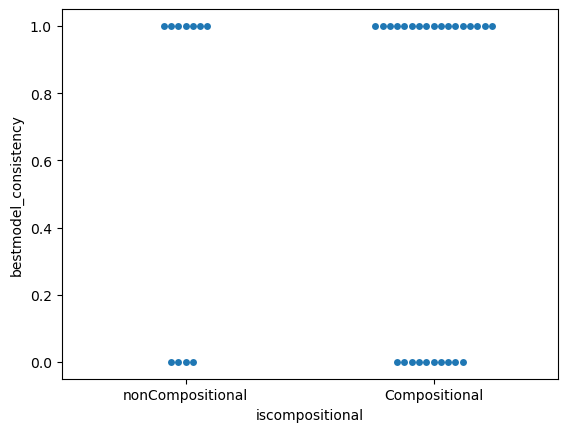

In [198]:
compositional_ids = np.unique(model_param_df[model_param_df.iscompositional=="Compositional"].subid)

sns.swarmplot(
    model_param_df.copy().drop_duplicates("subid"),
    x="iscompositional",
    y="bestmodel_consistency"
    )


In [199]:
model_param_df[model_param_df.modelnames==model_param_df.fit_bestmodel]

,lapse,sigma_x,sigma_y,modelnames,fit_AIC,test_AIC,fit_meantrialL,test_meantrialL,fit_bestmodel,test_bestmodel,subid,iscompositional,bestmodel_consistency
2,0.875000,NaN,1.000000e-20,1D-y,-212.524331,289.473355,766.155638,1.190180e-01,1D-y,compositional,0en2YwrgPZqq,nonCompositional,False
4,0.937500,4.066250e-01,1.000000e-20,compositional,-34.971543,87.592739,2.982795,5.251537e-01,compositional,compositional,aprCv5rFL8pN,Compositional,True
9,0.530858,6.293477e-01,NaN,1D-x,136.423358,538.801166,0.014077,1.902934e-02,1D-x,1D-x,bHAKEOQOX39l,nonCompositional,True
12,0.128204,6.167018e-01,6.102319e-01,compositional,55.467681,171.199567,0.176689,2.839888e-01,compositional,compositional,bjjQPvQtZ124,Compositional,True
16,0.216440,7.362805e-01,1.134213e+00,compositional,106.398175,456.713366,0.035975,3.479831e-02,compositional,compositional,CIHofsSopOIK,Compositional,True
20,0.140405,8.526163e-01,8.385739e-01,compositional,91.314445,436.478371,0.057638,4.038084e-02,compositional,compositional,Dg4Z9j33pfaS,Compositional,True
24,0.823533,9.188988e-01,3.098839e-01,compositional,138.997860,638.169937,0.012989,9.164426e-03,compositional,1D-y,e5F59k07mWB9,Compositional,False
28,0.000000,1.019170e+00,5.719969e-01,compositional,56.275455,3885.115934,0.172285,3.921904e-13,compositional,1D-x,ESg8ssLdSeH4,Compositional,False
34,0.973824,NaN,4.501506e-01,1D-y,149.925962,637.207357,0.009231,9.229520e-03,1D-y,1D-y,FZy8PSATlIm3,nonCompositional,True
36,0.937500,1.000000e-20,1.408590e-01,compositional,-39.212060,646.515892,3.405449,8.618939e-03,compositional,1D-y,GsxAkjUf8C3h,Compositional,False


In [140]:
#prob_func = lambda resp_x,resp_y,putative_x,putative_y,arena_r:trialwise_likelihood_1Dx(0.3,resp_x,resp_y,putative_x,putative_y,arena_r)
#prob_func = trialwise_likelihood_noncomporandom
for id in valid_exptid[1:2]:
    subdf = putativerespdata_test_df[(putativerespdata_test_df.subid == id)&(putativerespdata_test_df.stim_group == "validation")].copy().reset_index(drop=True)
    respxs,respys,putativexs,putativeys = list(subdf[["resp_x","resp_y","putative_x","putative_y"]].to_numpy().T)
    print(f"{id} :  {compute_llr_across_trials([],trialwise_likelihood_noncomporandom,respxs,respys,putativexs,putativeys)}")

aprCv5rFL8pN :  75.02807675293816


In [36]:
60/53/3

0.3773584905660377

In [173]:
arena_r = 5 + (1.42*60/53*1.1/2)
err_tol = 60/53
sigma = err_tol/3
prob_func = {
    "compositional": lambda x,y,probx,proby,randx,randy: probx*proby if (x**2+y**2)<=(arena_r**2) else np.nan,
    "1D-x":          lambda x,y,probx,proby,randx,randy: probx*randy if (x**2+y**2)<=(arena_r**2) else np.nan,
    "1D-y":          lambda x,y,probx,proby,randx,randy: randx*proby if (x**2+y**2)<=(arena_r**2) else np.nan,
    "noncompo-random": lambda x,y,probx,proby,randx,randy: disk_uniform(np.pi*(arena_r**2)) if (x**2+y**2)<=(arena_r**2) else np.nan
}
probs_ = dict(zip(prob_func.keys(),[[],[],[],[]]))
for resp_x,resp_y,putative_x,putative_y in putativerespdata_test_df[["resp_x","resp_y","putative_x","putative_y"]].to_numpy():
    hr_x = np.sqrt(arena_r**2-resp_y**2)
    hr_y = np.sqrt(arena_r**2-resp_x**2)  
    probx = univariate_truncated_gaussian(resp_x,putative_x,sigma,-hr_x,hr_x)
    proby = univariate_truncated_gaussian(resp_y,putative_y,sigma,-hr_y,hr_y)
    randx = univariate_uniform(resp_x,-hr_x,hr_x)
    randy = univariate_uniform(resp_y,-hr_y,hr_y)
    for k,func in prob_func.keys():
        probs_[k].append(func(resp_x,resp_y,probx,proby,randx,randy))


In [175]:
g_df.resp_x.to_numpy()

array([-3.47883598, -1.89153439, -3.71693122,  3.0952381 , -0.07936508,
       -0.06613757, -0.17195767, -1.69312169, -3.55820106, -0.15873016,
        0.01322751,  1.78571429, -0.10582011,  1.75925926, -0.1984127 ,
       -0.05291005])

In [12]:
from scipy.stats import truncnorm,uniform
def univariate_truncated_gaussian(x,mu,sigma,lb:float,ub:float):
    rv = truncnorm(lb, ub, loc=mu, scale=sigma**2)
    return rv.pdf(x)

def univariate_uniform(x,lb:float,ub:float):
    """_summary_

    Parameters
    ----------
    x : _type_
        _description_
    lb : float
        lower bound
    ub : float
        upper bound

    Returns
    -------
    _type_
        _description_
    """
    rv = uniform(lb, ub-lb)
    return rv.pdf(x)

def disk_uniform(area):
    return 1/area


In [13]:
# in js code: arena_r = 5*board.scale_factor + (1.42*cursor_h/2);
# so          arena_r = 5*board.scale_factor + (1.42*parameters.err_tol*1.1*board.scale_factor/2);
# so          arena_r = [5 + (1.42*parameters.err_tol*1.1/2)]*board.scale_factor;
# because:
# parameters.err_tol = 60*parameters.shrink/board.scale_factor;
# parameters.shrink  = min([w,h])*0.35/265;
# board.scale_factor = 53*parameters.shrink;
# so 
# parameters.err_tol = 60*parameters.shrink/53*parameters.shrink = 60/53;
# so in map 
#            arena_r = 5 + (1.42*60/53*1.1/2); 
arena_r = 5 + (1.42*60/53*1.1/2)
err_tol = 60/53

# generate locations to evaluate response at
v = np.linspace(-arena_r,arena_r,num=200,endpoint=True)
grid_x,grid_y = np.meshgrid(v,v)

# calculate response probability in this space
sample_resp_prob = {
    "compositional":[],
    "1D-x":[],
    "1D-y":[],
    "compo-random":[],
    "noncompo-random":[]
}
prob_func = {
    "compositional": lambda x,y,probx,proby,randx,randy: probx*proby if (x**2+y**2)<=(arena_r**2) else np.nan,
    "1D-x":          lambda x,y,probx,proby,randx,randy: probx*randy if (x**2+y**2)<=(arena_r**2) else np.nan,
    "1D-y":          lambda x,y,probx,proby,randx,randy: randx*proby if (x**2+y**2)<=(arena_r**2) else np.nan,
    #"compo-random":  lambda x,y,probx,proby,randx,randy: randx*randy if (x**2+y**2)<=(arena_r**2) else np.nan,
    "noncompo-random": lambda x,y,probx,proby,randx,randy: disk_uniform(np.pi*(arena_r**2)) if (x**2+y**2)<=(arena_r**2) else np.nan
}

true_x,true_y = 0,0
sample_probs = []
for x,y in zip(grid_x.flatten(),grid_y.flatten()):
    hr_x = np.sqrt(arena_r**2-y**2)
    hr_y = np.sqrt(arena_r**2-x**2)   
    probx = univariate_truncated_gaussian(x,true_x,err_tol/3,-hr_x,hr_x)
    proby = univariate_truncated_gaussian(y,true_y,err_tol/3,-hr_y,hr_y)
    randx = univariate_uniform(x,-hr_x,hr_x)
    randy = univariate_uniform(y,-hr_y,hr_y)
    sample_probs.append([pfunc(x,y,probx,proby,randx,randy) for mname,pfunc in prob_func.items()])




c:\Users\Zilu Liang\miniconda3\envs\piratefmri\lib\site-packages\scipy\stats\_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


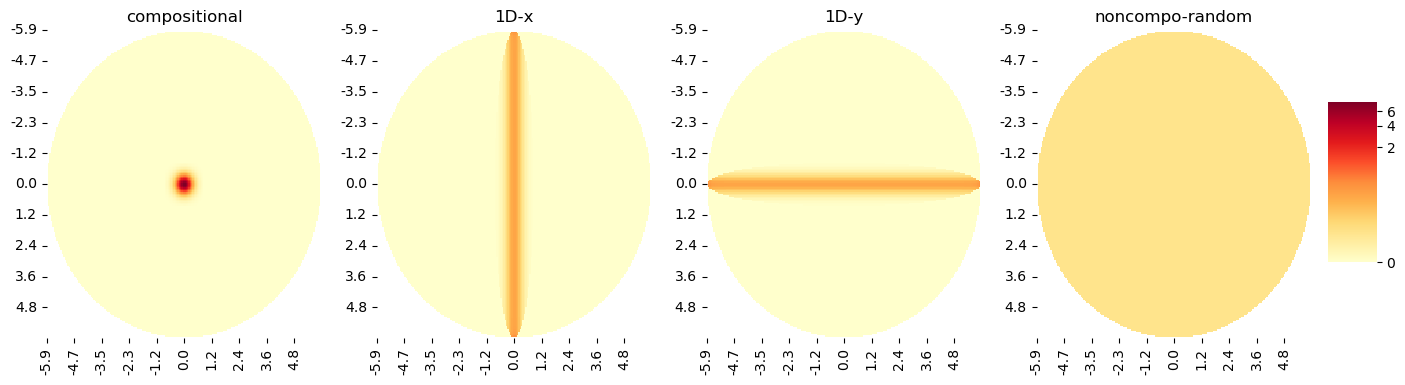

In [14]:
sample_probs_permodel = dict(zip(
    prob_func.keys(),
    [np.array(sample_probs)[:,j].reshape(grid_x.shape) for j in range(len(prob_func))]
))
sample_probs_permodel_normalized = dict(zip(
    sample_probs_permodel.keys(),
    [mat/np.nansum(mat) for mat in sample_probs_permodel.values()]
))

fig,axes = plt.subplots(1,len(prob_func),figsize=(4.08*len(prob_func),4))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
from matplotlib.colors import LogNorm, Normalize,PowerNorm,FuncNorm
#apply square root transform to colormap so that colors are visibal
cnorm = PowerNorm(vmin=0,
                  vmax=np.max([np.nanmax(x) for x in sample_probs_permodel.values()]),
                  gamma=0.25)

# cnorm = FuncNorm(vmin=0,
#                  vmax=np.max([np.nanmax(x) for x in sample_probs_permodel_normalized.values()]),
#                  functions=(
#                       lambda x: np.sqrt(x), #np.exp(np.sqrt(x)*100),
#                       lambda y: y**2 #(np.log(y)/100)**2,
#                   ))


for j,(ax,mname) in enumerate(zip(axes,prob_func.keys())):
    sns.heatmap(sample_probs_permodel[mname],ax=ax,
                cbar= j == 0, norm = cnorm,
                cmap="YlOrRd",
                cbar_ax=None if j else cbar_ax
                )
    tickloc = np.arange(10)*int(len(v)/10)
    ax.set_xticks(tickloc,labels=["%.1f" %x for x in v[tickloc]])
    ax.set_yticks(tickloc,labels=["%.1f" %x for x in v[tickloc]])
    ax.set_title(mname)


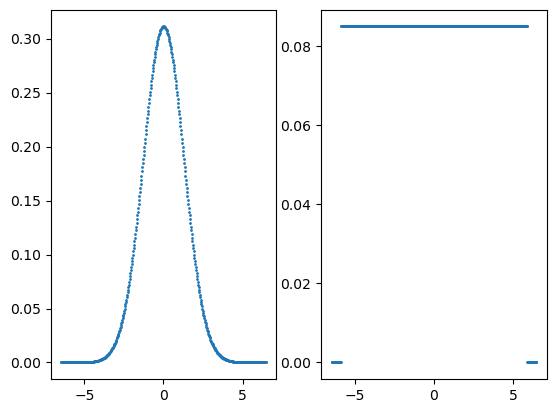

In [153]:
_,axes = plt.subplots(1,2)
xs = np.linspace(start=-arena_r*1.1,stop=arena_r*1.1,num=500,endpoint=True)
ys_tg = [univariate_truncated_gaussian(x,0,err_tol,-arena_r,arena_r) for x in xs]
ys_uf = [univariate_uniform(x,-arena_r,arena_r) for x in xs]

axes[0].scatter(xs,ys_tg,s=1)
axes[1].scatter(xs,ys_uf,s=1)


In [55]:
resp_x,resp_y = sub_final_pretrain_trainingresp[["resp_x","resp_y"]].to_numpy()[0]
putative_x,putative_y = sub_final_pretrain_trainingresp[["stim_x","stim_y"]].to_numpy()[0]

sigma=0.1
x_l = univariate_gaussian(resp_x,putative_x,sigma)
y_l = univariate_gaussian(resp_y,putative_y,sigma)
np.log(x_l),np.log(y_l)

(-12.603405850994628, 0.20274364490306213)

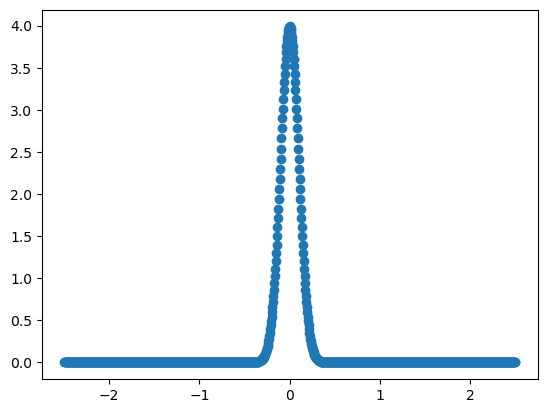